##Set up##

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
def show_img(x, figsize=(4, 3), **kwargs):
  plt.figure(figsize=figsize)
  plt.axis('off')
  if x.shape[0] == 3:
    x.permute(1, 2, 0)
  plt.imshow(x.cpu(), **kwargs)

In [3]:
cuda_begin=r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)
#define CUDA_ERR(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
__host__ __device__ inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a+b-1)/b;}
'''

def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False, name=None):
  if name is None:
    name = funcs[0]
  return load_inline(
      cpp_sources=cpp_src,
      cuda_sources=cuda_src,
      functions=funcs,
      extra_cflags=['-O2'] if opt else [],
      verbose=verbose,
      name=name
  )

def cdiv(a, b):
  return (a+b-1)//b

In [4]:
import os, math, sys, torch, re, numpy as np
from types import SimpleNamespace as ns
from collections import namedtuple

In [5]:
dim3 = namedtuple('dim3', ['x', 'y', 'z'], defaults=[1, 1])

In [6]:
d = dim3(2, 3)
d

dim3(x=2, y=3, z=1)

In [7]:
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [8]:
sys.path.insert(0, '..')

In [9]:
%pip install -q wurlitzer ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 5.8 MB/s eta 0:00:00


In [10]:
%load_ext wurlitzer

In [11]:
torch.manual_seed(42)

In [12]:
m1 = torch.randn(5120, 256)
m1s = m1[:4,:]
m2 = torch.randn(256, 5120)
m2s = m2[:,:4]
print(m1s.shape, m2s.shape)

torch.Size([4, 256]) torch.Size([256, 4])


###CUDA###

In [26]:
cuda_src=cuda_begin + r'''
__global__ void matmul_kernel(float *a, float *b, float *c, int m, int k, int n) {
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (row < m && col < n) {
    float sum = 0.0f;
    for (int i = 0; i < k; i++) {
      sum += a[row * k + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }
}


torch::Tensor matmul(torch::Tensor a, torch::Tensor b) {
  CHECK_INPUT(a);
  CHECK_INPUT(b);
  const auto m = a.size(0);
  const auto k = a.size(1);
  const auto n = b.size(1);

  torch::Tensor c = torch::zeros({m, n}, a.options());

  dim3 block_size(16, 16);
  dim3 grid_size((n + block_size.x - 1) / block_size.x, (m + block_size.y - 1) / block_size.y);
  matmul_kernel<<<grid_size, block_size>>>(a.data_ptr<float>(), b.data_ptr<float>(), c.data_ptr<float>(), m, k, n);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return c;
}
'''

In [27]:
cpp_src = "torch::Tensor matmul(torch::Tensor a, torch::Tensor b);"

In [28]:
module = load_cuda(cuda_src, cpp_src, ['matmul'], opt=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [22]:
m1c, m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

%time
module.matmul(m1c, m2c).shape

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


torch.Size([5120, 5120])

In [50]:
torch.isclose(module.matmul(m1c, m2c), m1c@m2c).all()

tensor(True, device='cuda:0')

In [25]:
%%timeit -n 10
module.matmul(m1c, m2c)
torch.cuda.synchronize()

20.8 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


###tiling###

setup: A $\in$ $R^{m * k}$, B $\in$ $R^{k * n}$

Naive approach limitation:

for every element (i, j) in the result C of A x B, it requires to load row i of A and col j of B. We thus need to load each row from A m times, leading to accessing each element in A m times. Similarly, we need to load each col in B n times, leading to accessing each element in B n times.

One more limitation is, when loading from the memory, row-wise is not favored, as threads requiring elements from other rows of A cannot start.

Tiling:

The basic idea is to chunk-wisely calculate the partial sum of an element, and then sum together. Shown on the following graph, if we want to get the result of elements in tile_(0, 0), we would load tile_(0, 0) from A and tile_(0, 0) from B to get partial sum. Then tile_(0, 1) from A and tile_(1, 0) from B, etc to the shared memory.

Each thread_{row, col} than has two tasks (row, col here is the global index, which can be obtained by blockIdx, blockDim and threadIdx).
1. load the (i, j) element of each Tile (i, j here is the local index of the thread)
2. calculate the tile-wise dot product

By using tiling, since we are load each element one by one from the memory, the memory coalescing issue is minimal. Furthermore, with some mathematics, you will notice that each element in A will only be accessed up to m / tile_size times, and B will only be accessed up to n / tile_size times. The reason for this reduction is we reuse the already loaded element from A and B for different elements in C

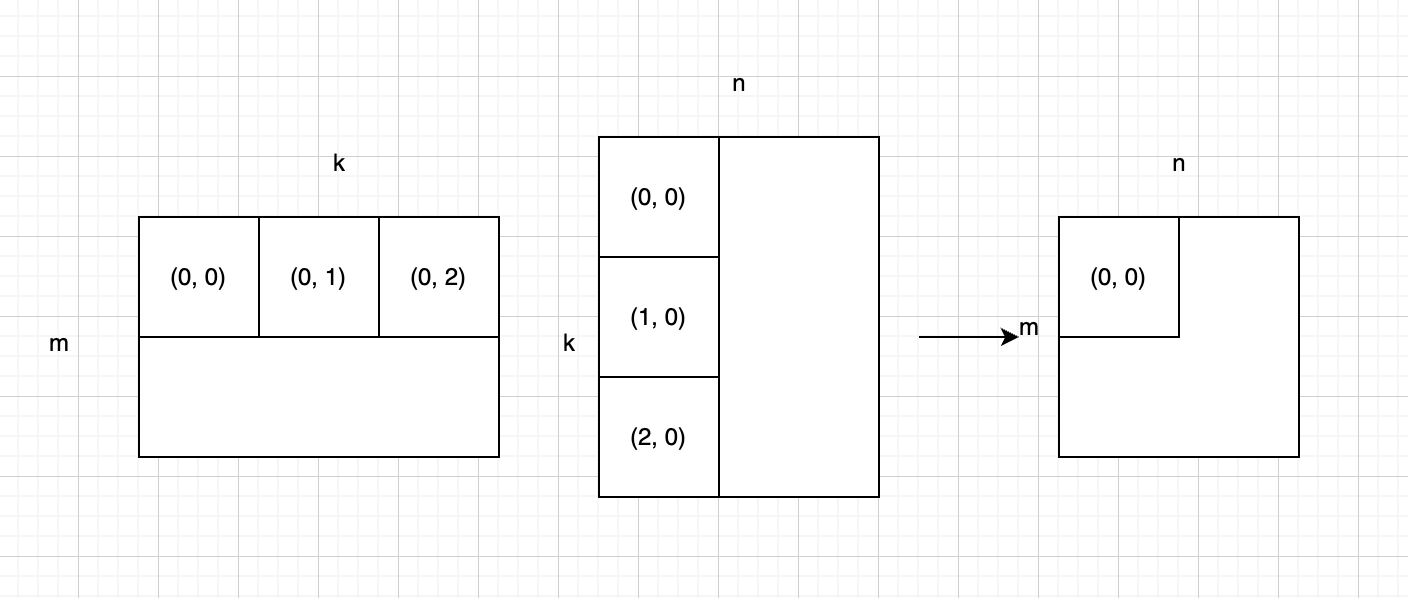


In [20]:
cuda_src = cuda_begin + r'''
constexpr int TILE_SIZE = 16;

__global__ void matmul_tile(float *a, float *b, float *c, int m, int k, int n) {
    __shared__ float sharedA[TILE_SIZE][TILE_SIZE];
    __shared__ float sharedB[TILE_SIZE][TILE_SIZE];

    // simpler notation
    int by = blockIdx.y, bx = blockIdx.x;
    int ty = threadIdx.y, tx = threadIdx.x;

    // global index of row and col of current thread
    int row = by * blockDim.y + ty;
    int col = bx * blockDim.x + tx;

    float sum = 0.0f;

    for (int tile = 0; tile < (k + TILE_SIZE - 1) / TILE_SIZE; ++tile) {
        // if row and tile * TILE_SIZE + tx are within A, set A, else set nothing
        if (row < m && tile * TILE_SIZE + tx < k) {
            sharedA[ty][tx] = a[row * k + tile * TILE_SIZE + tx];
        } else {
            sharedA[ty][tx] = 0.0f;
        }
        if (tile * TILE_SIZE + ty < k && col < n) {
            sharedB[ty][tx] = b[(tile * TILE_SIZE + ty) * n + col];
        } else {
            sharedB[ty][tx] = 0.0f;
        }
        // wait other threads to finish
        __syncthreads();

        for (int l = 0; l < TILE_SIZE; ++l) {
            sum += sharedA[ty][l] * sharedB[l][tx];
        }

        __syncthreads();
    }

    if (row < m && col < n) {
        c[row * n + col] = sum;
    }
}

torch::Tensor matmul(torch::Tensor a, torch::Tensor b) {
    CHECK_INPUT(a);
    CHECK_INPUT(b);
    int m = a.size(0);
    int k = a.size(1);
    int n = b.size(1);
    torch::Tensor c = torch::zeros({m, n}, a.options());
    dim3 block_size(TILE_SIZE, TILE_SIZE);
    dim3 grid_size((n + TILE_SIZE - 1) / TILE_SIZE, (m + TILE_SIZE - 1) / TILE_SIZE);
    matmul_tile<<<grid_size, block_size>>>(a.data_ptr<float>(), b.data_ptr<float>(), c.data_ptr<float>(), m, k, n);
    return c;
}
'''

In [14]:
cpp_src = "torch::Tensor matmul(torch::Tensor a, torch::Tensor b);"

In [21]:
module = load_cuda(cuda_src, cpp_src, ['matmul'], opt=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [23]:
torch.isclose(module.matmul(m1c, m2c), m1c@m2c).all()

tensor(True, device='cuda:0')

In [24]:
%%timeit -n 10
module.matmul(m1c, m2c)
torch.cuda.synchronize()

20.9 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
